In [273]:
import json

json_path: str = "./coco/panoptic_val2017.json"
with open(json_path) as file:
    json_annotations = json.loads("".join(file.readlines()))

ALL = [
    category["id"]
    for category in json_annotations["categories"]
    ]

VEHICLES = [
    category["id"]
    for category in json_annotations["categories"]
    if category["supercategory"] == "vehicle"
    ]

CATEGORIES = {
    category["id"]: category["name"]
    for category in json_annotations["categories"]
    }


In [274]:

from enum import Enum


class Categories(Enum):
    ALL = ALL
    VEHICLES = VEHICLES


In [1]:
from mmdet.models.detectors.single_stage import SingleStageDetector
from mmdet.apis import init_detector, inference_detector

config_file = 'yolov3_mobilenetv2_320_300e_coco.py'

checkpoint_file = \
    'yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth'

model = init_detector(config_file, checkpoint_file, device="cpu")


/home/nolok/anaconda3/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth


In [276]:
def get_mmdet_rects(
        file_path: str,
        model: SingleStageDetector,
        printing: bool = True,
        min_score: float = 0.6,
        ) -> list[list[int, int, int, int]]:

    rectangles = []
    scores = []

    results = inference_detector(model, file_path)

    for class_idx in range(len(results)):
        class_results = results[class_idx]
        for detection in class_results:
            score = detection[-1]
            scores.append(score)
            if score > min_score:
                rect = [int(el) for el in detection[:-1]]

                bbox_left, bbox_top, bbox_right, bbox_bottom = rect
                bbox_width = bbox_right - bbox_left
                bbox_height = bbox_bottom - bbox_top

                new_rect = (bbox_left, bbox_top, bbox_width, bbox_height)
                rectangles.append(new_rect)

    if printing:
        print("--- mmdet score ---")
        print("min\tmax\tavg")
        print(
            round(min(scores), 3),
            round(max(scores), 3),
            round(sum(scores)/len(scores), 3),
            sep="\t"
            )
        print("--- < < --- > > ---")

    return rectangles


def get_coco_rects(
        file_segments: list[list[int, int, int, int]]
        ) -> list[list[int, int, int, int]]:

    rects: list = []

    for rect in file_segments:
        rects.append(rect)

    return rects


In [277]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def draw_rectangles(
        file_path: str, 
        coco_rects: list,
        mmdet_rects: list
        ) -> None:

    img = Image.open(file_path)

    # wyświetlenie obrazka
    plt.imshow(img)

    # dodanie prostokątów coco na obrazku
    for rect in coco_rects:
        bbox_left, bbox_top, bbox_width, bbox_height = rect

        rect = patches.Rectangle(
            (bbox_left, bbox_top),
            bbox_width, bbox_height,
            linewidth=1, edgecolor="r", facecolor="none"
            )

        plt.gca().add_patch(rect)


    # dodanie prostokątów mmdet na obrazku
    for rect in mmdet_rects:
        bbox_left, bbox_top, bbox_width, bbox_height = rect

        rect = patches.Rectangle(
            (bbox_left, bbox_top),
            bbox_width, bbox_height,
            linewidth=1, edgecolor="b", facecolor="none"
            )

        plt.gca().add_patch(rect)

    # wyświetlenie obrazka z prostokątem
    plt.show()


In [278]:
def jaccard_index(
        rect1: tuple[int, int, int, int],
        rect2: tuple[int, int, int, int]
        ) -> float:
    """
    Calc Jaccard Index.
    Jaccard similarity coefficient is a measure of similarity between two sets.
    It takes values from the range [0, 1], 
    where 0 means no similarity and1 means sets are identical.

    Input:
        * rect1: tuple[int, int, int, int] - (x, y, widht, height)
        * rect2: tuple[int, int, int, int] - (x, y, widht, height)
    Output:
        * index: float - value between <0, 1>
    """
    # Obliczenie koordynat prostokąta wynikowego
    x_left = max(rect1[0], rect2[0])
    y_top = max(rect1[1], rect2[1])
    x_right = min(rect1[0] + rect1[2], rect2[0] + rect2[2])
    y_bottom = min(rect1[1] + rect1[3], rect2[1] + rect2[3])

    # Obliczenie pola wspólnego obszaru A ∩ B
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Obliczenie pola sumy obszarów A i B
    union_area = rect1[2] * rect1[3] + rect2[2] * rect2[3] - intersection_area

    # Obliczenie indeksu Jaccarda
    jaccard_index = intersection_area / union_area

    return jaccard_index


In [279]:
def get_files_annotations(
        json_annotations: dict,
        annotation_classes: tuple[int]
        ) -> dict[str, list[tuple[int, int, int, int]]]:
    
    """
    Input:
        * json_annotations: dict - panoptic_val2017.json as dict
        * annotation_classes: tuple[int] - target annotation classes ids

    Output:
        * annotations: dict[str, list[tuple[int, int, int, int]]] - dict where
            key is a file name and values are rects with annotations
    """

    annotations: dict[str, list[list[int, int, int, int]]] = {}

    for file_json in json_annotations["annotations"]:
        segments_json = [
            segment
            for segment in file_json["segments_info"]
            if segment["category_id"] in annotation_classes
            ]
        # print(CATEGORIES[segment["category_id"]])
        if len(segments_json) > 2:
            file_name = file_json["file_name"].replace("png", "jpg")
            segments = [segment["bbox"] for segment in segments_json]

            annotations[file_name] = segments

    return annotations


In [284]:
def filter_rectangles(
        rects1: list[tuple[int, int, int, int]],
        rects2: list[tuple[int, int, int, int]],
        min_jaccard_index: float = 0.7
        ) -> tuple[list[tuple], list[tuple]]:

    ji_all = []
    ji_ok = []

    pairs: dict = {}
    for r1 in rects1:
        for r2 in rects2:
            ji = jaccard_index(r1, r2)
            ji_all.append(ji)
            if ji >= min_jaccard_index:
                if (
                    (tuple(r1), tuple(r2)) not in pairs
                    or (tuple(r2), tuple(r1)) not in pairs
                ): 
                    ji_ok.append(ji)
                    pairs[(tuple(r1), tuple(r2))] = ji

    sorted_pairs = sorted(pairs, key=pairs.get)
    if len(sorted_pairs) == 0:
        return [], [], -1, -1

    list1 = []
    list2 = []
    for pair in sorted_pairs:
        list1.append(pair[0])
        list2.append(pair[1])

    return list1, list2, sum(ji_all)/len(ji_all), sum(ji_ok)/len(ji_ok)


--- mmdet score ---
min	max	avg
0.002	0.925	0.082
--- < < --- > > ---


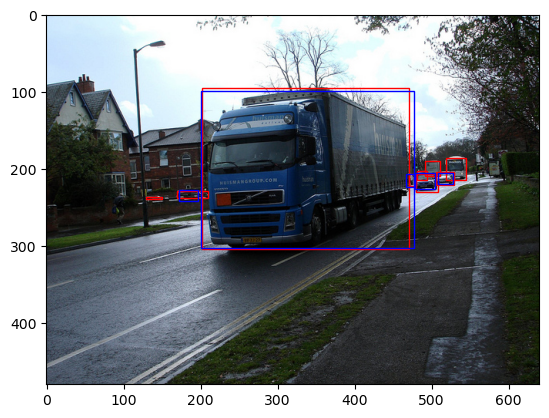

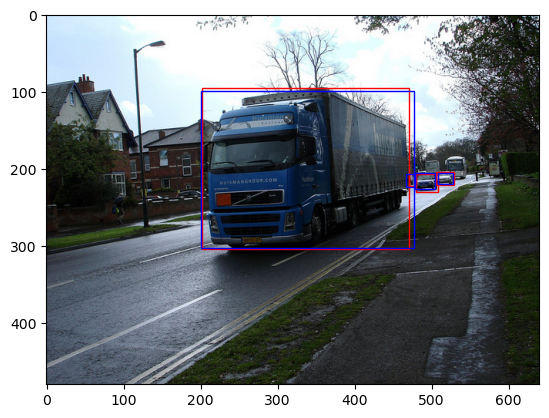

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.7092861256680535
AVG Jaccard Index (all): 0.0823893165116081


In [285]:
# EXAMPLE OF USING

files = get_files_annotations(json_annotations, Categories.VEHICLES.value)

if True:
    file_path = "./coco/images/000000033109.jpg"
    min_ji_index = 0.5

    coco_rects = get_coco_rects(files[file_path.split("/")[-1]])
    mmdet_rects = get_mmdet_rects(file_path, model)

    draw_rectangles(file_path, coco_rects, mmdet_rects)

    sorted_coco_rect, sorted_mmdet_rect, ji_avg1, ji_avg2 = filter_rectangles(
        coco_rects, mmdet_rects, min_ji_index
        )

    draw_rectangles(file_path, sorted_coco_rect, sorted_mmdet_rect)
    print("MIN Jaccard Index:", min_ji_index)
    print("AVG Jaccard Index (ok):", ji_avg2)
    print("AVG Jaccard Index (all):", ji_avg1)


--- mmdet score ---
min	max	avg
0.004	0.978	0.061
--- < < --- > > ---
--- mmdet score ---
min	max	avg
0.006	0.905	0.074
--- < < --- > > ---


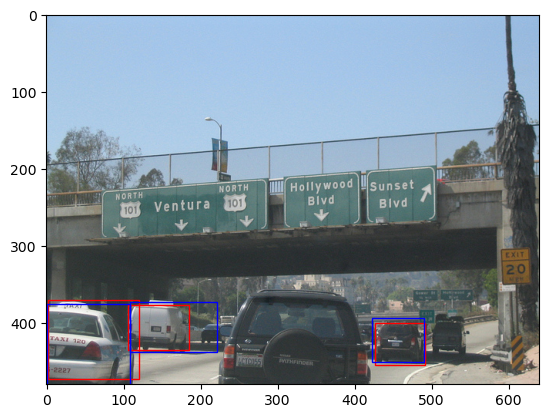

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.7304672547190444
AVG Jaccard Index (all): 0.09835837551311255
--- mmdet score ---
min	max	avg
0.006	0.999	0.082
--- < < --- > > ---


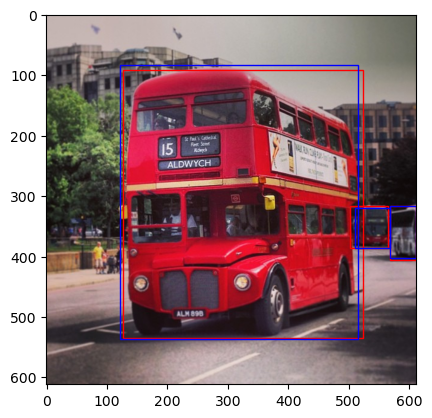

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.9087137172704695
AVG Jaccard Index (all): 0.2279981063388895
--- mmdet score ---
min	max	avg
0.009	0.293	0.038
--- < < --- > > ---
--- mmdet score ---
min	max	avg
0.007	0.999	0.08
--- < < --- > > ---


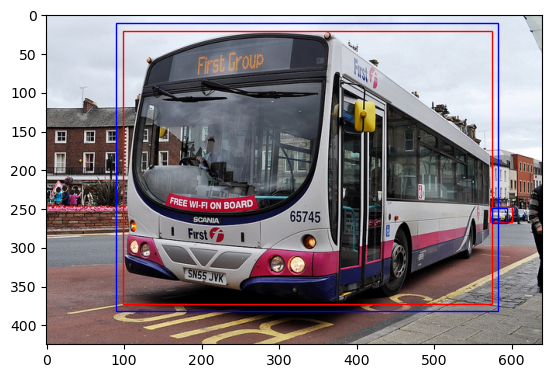

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.7850530556166924
AVG Jaccard Index (all): 0.13432752428313824
--- mmdet score ---
min	max	avg
0.001	0.966	0.047
--- < < --- > > ---


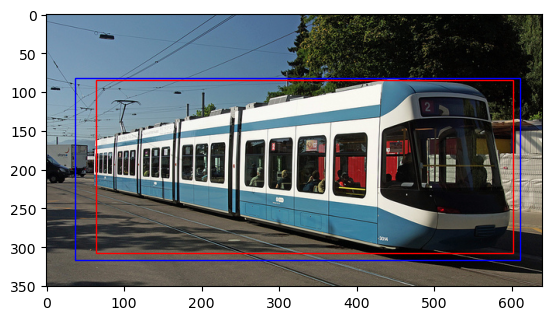

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.893221954197564
AVG Jaccard Index (all): 0.3000741339384279
--- mmdet score ---
min	max	avg
0.004	0.641	0.062
--- < < --- > > ---


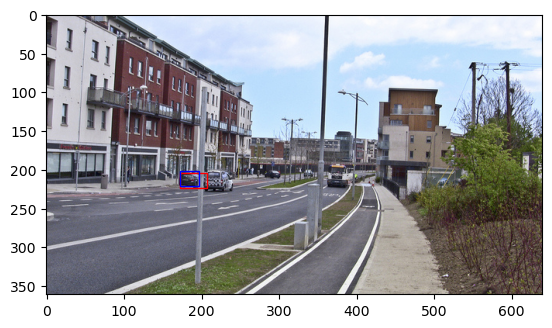

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.5722300140252454
AVG Jaccard Index (all): 0.11444600280504909
--- mmdet score ---
min	max	avg
0.002	0.697	0.017
--- < < --- > > ---


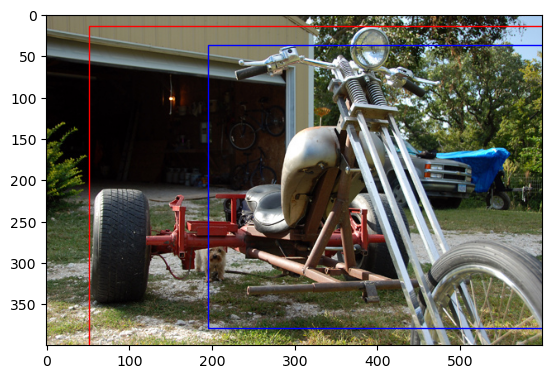

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.645689112649465
AVG Jaccard Index (all): 0.1946193726829337
--- mmdet score ---
min	max	avg
0.008	0.973	0.058
--- < < --- > > ---


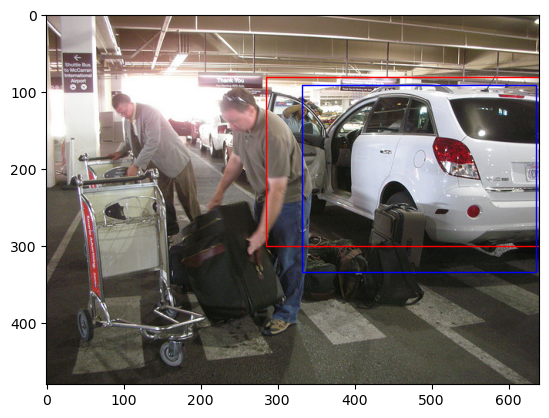

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.7163525712087961
AVG Jaccard Index (all): 0.1109883624382758
--- mmdet score ---
min	max	avg
0.001	0.947	0.042
--- < < --- > > ---


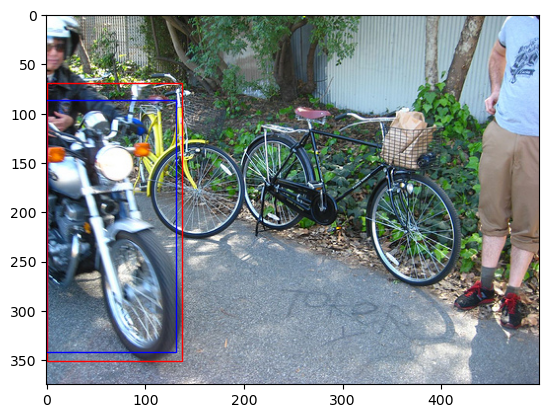

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.8623296477243507
AVG Jaccard Index (all): 0.16587656383735852
--- mmdet score ---
min	max	avg
0.011	0.962	0.102
--- < < --- > > ---
--- mmdet score ---
min	max	avg
0.008	0.732	0.044
--- < < --- > > ---


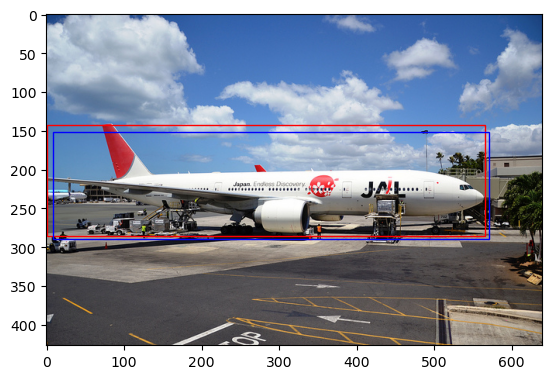

MIN Jaccard Index: 0.5
AVG Jaccard Index (ok): 0.8922078383532115
AVG Jaccard Index (all): 0.15320025673587423

AVG of all Jaccard Indexes: 0.7784739073072043


In [291]:
min_ji_index = 0.5
ji_avg_list = []

for i, file_name in enumerate(files):
    file_path = f"./coco/images/{file_name}"

    coco_rects = get_coco_rects(files[file_path.split("/")[-1]])
    mmdet_rects = get_mmdet_rects(file_path, model)

    sorted_coco_rect, sorted_mmdet_rect, ji_avg1, ji_avg2 = filter_rectangles(
        coco_rects, mmdet_rects, min_ji_index
        )

    if ji_avg2 >= 0:
        draw_rectangles(file_path, sorted_coco_rect, sorted_mmdet_rect)
        print("MIN Jaccard Index:", min_ji_index)
        print("AVG Jaccard Index (ok):", ji_avg2)
        print("AVG Jaccard Index (all):", ji_avg1)

        ji_avg_list.append(ji_avg2)

    if i > 10:
        break

print()
print("AVG of all Jaccard Indexes:", sum(ji_avg_list)/len(ji_avg_list))


In [296]:
min_ji_index = 0.5
ji_avg_list = []

for i, file_name in enumerate(files):
    file_path = f"./coco/images/{file_name}"

    coco_rects = get_coco_rects(files[file_path.split("/")[-1]])
    mmdet_rects = get_mmdet_rects(file_path, model, False)

    sorted_coco_rect, sorted_mmdet_rect, ji_avg1, ji_avg2 = filter_rectangles(
        coco_rects, mmdet_rects, min_ji_index
        )

    if ji_avg2 >= 0:
        ji_avg_list.append(ji_avg2)

    # if i > 100:
        # break

print()
print("Files:", len(ji_avg_list))
print("AVG of all Jaccard Indexes:", sum(ji_avg_list)/len(ji_avg_list))



Files: 312
AVG of all Jaccard Indexes: 0.7837983298153437
